# **Accessing CMIP6 catalogs with intake-esm**

This notebook is useful if you want to use data that is not represented in the shared folders on the jupyterhub.

First, load `intake` and `intake-esm` 
(We will also need to suppress some annoying future warnings).

In [1]:
import intake
import intake_esm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



Then, you can open a catalog file from a known dataset, f.e. [Pangeo CMIP6 google cloud](https://pangeo-data.github.io/pangeo-cmip6-cloud/)



In [2]:
cat = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


The summary above tells us that this catalog contains 7674 data assets. You can get more information on the individual data assets contained in the catalog by looking at the underlying dataframe created when we load the catalog:

In [3]:
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


## Finding unique entries
To get unique values for given columns in the catalog, intake-esm provides a unique() method:

Let’s query the data catalog to see what models(source_id), experiments (experiment_id) and temporal frequencies (table_id) are available.

In [4]:
unique = cat.unique()
unique

activity_id            [HighResMIP, CMIP, CFMIP, ScenarioMIP, AerChem...
institution_id         [CMCC, EC-Earth-Consortium, MOHC, ECMWF, NOAA-...
source_id              [CMCC-CM2-HR4, EC-Earth3P-HR, HadGEM3-GC31-MM,...
experiment_id          [highresSST-present, piControl, control-1950, ...
member_id              [r1i1p1f1, r1i3p1f1, r1i2p1f1, r1i1p1f2, r2i1p...
table_id               [Amon, 6hrPlev, 3hr, day, EmonZ, E3hr, 6hrPlev...
variable_id            [ps, rsds, rlus, rlds, psl, hurs, huss, hus, h...
grid_label             [gn, gr, gr1, grz, gr2, gr2z, gr1z, gr3, gm, gnz]
zstore                 [gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4...
dcpp_init_year         [1920.0, 1992.0, 2007.0, 2006.0, 2008.0, 1968....
version                [20170706, 20170811, 20170818, 20170831, 20170...
derived_variable_id                                                   []
dtype: object

In [5]:
unique['source_id']

['CMCC-CM2-HR4',
 'EC-Earth3P-HR',
 'HadGEM3-GC31-MM',
 'HadGEM3-GC31-HM',
 'HadGEM3-GC31-LM',
 'EC-Earth3P',
 'ECMWF-IFS-HR',
 'ECMWF-IFS-LR',
 'HadGEM3-GC31-LL',
 'CMCC-CM2-VHR4',
 'GFDL-CM4',
 'GFDL-AM4',
 'IPSL-CM6A-LR',
 'E3SM-1-0',
 'CNRM-CM6-1',
 'GFDL-ESM4',
 'GFDL-ESM2M',
 'GFDL-CM4C192',
 'GFDL-OM4p5B',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'CNRM-ESM2-1',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'MIROC6',
 'AWI-CM-1-1-MR',
 'EC-Earth3-LR',
 'IPSL-CM6A-ATM-HR',
 'CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1-HR',
 'MRI-ESM2-0',
 'SAM0-UNICON',
 'GISS-E2-1-G-CC',
 'UKESM1-0-LL',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'FGOALS-f3-L',
 'CanESM5',
 'CanESM5-CanOE',
 'INM-CM4-8',
 'INM-CM5-0',
 'NESM3',
 'MPI-ESM-1-2-HAM',
 'CAMS-CSM1-0',
 'MPI-ESM1-2-LR',
 'MPI-ESM1-2-HR',
 'MRI-AGCM3-2-H',
 'MRI-AGCM3-2-S',
 'MCM-UA-1-0',
 'INM-CM5-H',
 'KACE-1-0-G',
 'NorESM2-LM',
 'FGOALS-f3-H',
 'FGOALS-g3',
 'MIROC-ES2L',
 'FIO-ESM-2-0',
 'NorCPM1',
 'NorESM1-F',
 'MPI-ESM1-2-XR',
 'CESM1-1-CAM5-CMIP5',
 'E3SM-1-1',
 'KIOST

In [6]:
unique['experiment_id']

['highresSST-present',
 'piControl',
 'control-1950',
 'hist-1950',
 'historical',
 'amip',
 'abrupt-4xCO2',
 'abrupt-2xCO2',
 'abrupt-0p5xCO2',
 '1pctCO2',
 'ssp585',
 'esm-piControl',
 'esm-hist',
 'hist-piAer',
 'histSST-1950HC',
 'ssp245',
 'hist-1950HC',
 'histSST',
 'piClim-2xVOC',
 'piClim-2xNOx',
 'piClim-2xdust',
 'piClim-2xss',
 'piClim-histall',
 'hist-piNTCF',
 'histSST-piNTCF',
 'aqua-control-lwoff',
 'piClim-lu',
 'histSST-piO3',
 'piClim-CH4',
 'piClim-NTCF',
 'piClim-NOx',
 'piClim-O3',
 'piClim-HC',
 'faf-heat-NA0pct',
 'ssp370SST-lowCH4',
 'piClim-VOC',
 'ssp370-lowNTCF',
 'piClim-control',
 'piClim-aer',
 'hist-aer',
 'faf-heat',
 'faf-heat-NA50pct',
 'ssp370SST-lowNTCF',
 'ssp370SST-ssp126Lu',
 'ssp370SST',
 'ssp370pdSST',
 'histSST-piAer',
 'piClim-ghg',
 'piClim-anthro',
 'faf-all',
 'hist-nat',
 'hist-GHG',
 'ssp119',
 'piClim-histnat',
 'piClim-4xCO2',
 'ssp370',
 'piClim-histghg',
 'highresSST-future',
 'esm-ssp585-ssp126Lu',
 'ssp126-ssp370Lu',
 'ssp370-ssp126

In [7]:
unique['table_id']

['Amon',
 '6hrPlev',
 '3hr',
 'day',
 'EmonZ',
 'E3hr',
 '6hrPlevPt',
 'AERmon',
 'LImon',
 'CFmon',
 'Lmon',
 'fx',
 'SImon',
 'Ofx',
 'Omon',
 'EdayZ',
 'Emon',
 'CFday',
 'AERday',
 'Eday',
 'Oyr',
 'Eyr',
 'Oday',
 'SIday',
 'AERmonZ',
 '6hrLev',
 'E1hrClimMon',
 'CF3hr',
 'AERhr',
 'Odec',
 'Oclim',
 'Efx',
 'Aclim',
 'SIclim',
 'IfxGre',
 'ImonGre',
 'Eclim']

The `search()`` method allows the user to perform a query on a catalog using keyword arguments. The keyword argument names must match column names in the catalog. The search method returns a subset of the catalog with all the entries that match the provided query.

In the example below, we are going to search for the following:

* source: `CESM2` model
* experiment: `historical`
* member: `r1ip1f1` ensemble member
* table: `Lmon` Land monthly
* variable: `tsl` Temperature of a soil layer °K



In [8]:
cat_subset = cat.search(
    source_id = "CESM2",
    experiment_id = "historical",
    member_id = "r1i1p1f1",
    table_id = "Lmon",
    variable_id = "tsl"
)

We will get 1 dataset, however, you can supply lists to the `search()` keyword arguments, f.e. `experiment_id=["historical","ssp585"]`.

In [9]:
cat_subset

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,1
table_id,1
variable_id,1
grid_label,1
zstore,1
dcpp_init_year,0


Intake-esm implements convenience utilities for loading the query results into higher level xarray datasets. The logic for merging/concatenating the query results into higher level xarray datasets is provided in the input JSON file and is available under `.aggregation_info` property of the catalog:

In [10]:
cat.esmcat.aggregation_control

AggregationControl(variable_column_name='variable_id', groupby_attrs=['activity_id', 'institution_id', 'source_id', 'experiment_id', 'table_id', 'grid_label'], aggregations=[Aggregation(type=<AggregationType.union: 'union'>, attribute_name='variable_id', options={}), Aggregation(type=<AggregationType.join_new: 'join_new'>, attribute_name='member_id', options={'coords': 'minimal', 'compat': 'override'}), Aggregation(type=<AggregationType.join_new: 'join_new'>, attribute_name='dcpp_init_year', options={'coords': 'minimal', 'compat': 'override'})])

Now, let's load some extra modules

In [11]:
import xarray
import gcsfs

And open our dataset as a dictionary of xarray.Dataset's, wait until the bar is 100%.

In [12]:
dset_dict = cat_subset.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True},
)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [13]:
[key for key in dset_dict.keys()]


['CMIP.NCAR.CESM2.historical.Lmon.gn']

Now, lets take one value from the dictionary and plot something.

In [14]:
ds = dset_dict['CMIP.NCAR.CESM2.historical.Lmon.gn']
ds

<xarray.Dataset>
Dimensions:         (depth: 25, hist_interval: 2, lat: 192, lon: 288,
                     time: 1980, member_id: 1, dcpp_init_year: 1)
Coordinates:
  * depth           (depth) float64 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
    depth_bnds      (depth, hist_interval) float32 dask.array<chunksize=(25, 2), meta=np.ndarray>
  * lat             (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lat_bnds        (lat, hist_interval) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon             (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lon_bnds        (lon, hist_interval) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time            (time) object 1850-01-15 11:45:00.000013 ... 2014-12-15 1...
    time_bnds       (time, hist_interval) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: hist_interval
Data variables:
    tsl             (member_id, dcpp_init_year, time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 60, 25, 192, 288), meta=np.ndarray>
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            219000.0
    case_id:                          15
    ...                               ...
    intake_esm_attrs:variable_id:     tsl
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2/histor...
    intake_esm_attrs:version:         20190308
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Lmon.gn

Now we will convert soil temperatures to Celsius within the same dataset:

In [15]:
ds["tsl"].values=ds["tsl"].values - 273.15

In [16]:
attrs = ds.tsl.attrs
attrs.update({"units" : "C"})
ds["tsl"].attrs=attrs

We can pass the variable in the dataset into a xarray.DataArray and plot it.

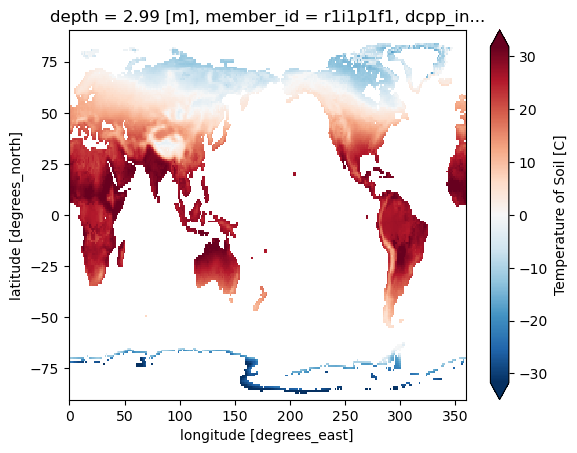

In [31]:
tsl=ds.tsl.sel(time=slice("2000-01","2000-12")).sel(depth=3.0, method="nearest").mean(dim='time',keep_attrs=True)
tsl.plot(robust=True)


We can also load cartopy and make a better plot with a contour denoting extent of frozen ground in the northern hemisphere.

In [34]:
import cartopy.crs as ccrs

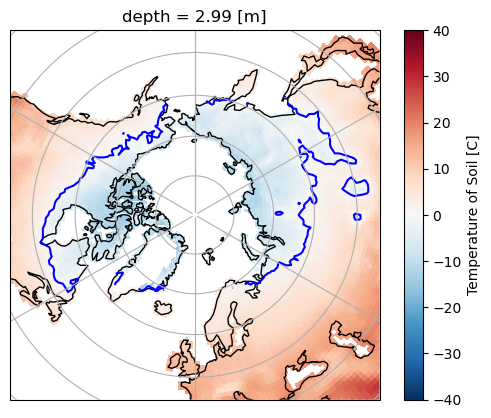

In [95]:
p = tsl.squeeze(drop=True).plot(subplot_kws=dict(projection=ccrs.NorthPolarStereo(), facecolor="white"), transform=ccrs.PlateCarree(),)
p.axes.gridlines()
p.axes.coastlines()
c = tsl.squeeze(drop=True).plot.contour(ax=p.axes,levels=[0],colors='blue',transform=ccrs.PlateCarree())
p.axes.set_extent((-180,180,45,90),ccrs.PlateCarree())
